In [1]:
# general packages
import numpy as np
import pandas as pd
import datatable as dt
import gc

#model
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Tools and metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from statlearning import plot_feature_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
%%time
data = pd.read_csv('features_processed.csv') 

Wall time: 29.9 s


In [3]:
data = data.iloc[:,1:]

In [4]:
data.iloc[:,:]

,Conditions,AreaNumber,PuLat,PuLong,create_by_hour,request_by_hour,pick,BookingSource_Internet,BookingSource_Permanent,BookingSource_StratumIVR,...,create_part_of_day_Afternoon,create_part_of_day_Evening,create_part_of_day_Morning,create_part_of_day_Night,request_part_of_day_Afternoon,request_part_of_day_Evening,request_part_of_day_Morning,request_part_of_day_Night,BookingisDispatch_False,BookingisDispatch_True
0,0,177,-33.921022,151.244202,10,11,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
1,0,111,-33.755931,151.273028,9,9,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,0,92,-33.897201,151.261205,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,1
3,0,182,-33.895716,151.228609,9,9,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
4,0,4,-33.859737,151.213307,21,21,1,1,0,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299995,0,265,-33.827898,151.126799,20,6,1,1,0,0,...,0,1,0,0,0,0,1,0,1,0
3299996,0,149,-33.712023,151.095004,17,17,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3299997,0,219,-33.850450,151.134428,8,8,1,0,0,1,...,0,0,1,0,0,0,1,0,0,1
3299998,0,177,-33.915317,151.251008,8,8,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0


In [5]:
data.dtypes.head(10)

Conditions                    int64
AreaNumber                    int64
PuLat                       float64
PuLong                      float64
create_by_hour                int64
request_by_hour               int64
pick                          int64
BookingSource_Internet        int64
BookingSource_Permanent       int64
BookingSource_StratumIVR      int64
dtype: object

## 1.Training and validation data split

In [6]:
training_data = data.iloc[:3000000,:]
validation_data = data.iloc[3000000:,:]

In [7]:
y_train = training_data[['TargetVariable_Cancelled','TargetVariable_Completed','TargetVariable_ELSE','TargetVariable_No Job']]
X_train = training_data.drop(columns=['TargetVariable_Cancelled','TargetVariable_Completed','TargetVariable_ELSE','TargetVariable_No Job'])
y_val = validation_data[['TargetVariable_Cancelled','TargetVariable_Completed','TargetVariable_ELSE','TargetVariable_No Job']]
X_val = validation_data.drop(columns=['TargetVariable_Cancelled','TargetVariable_Completed','TargetVariable_ELSE','TargetVariable_No Job'])

## 2.Modeling

Setup cross validation and define error metrics

### 2.1 Logistic Classifier

In [8]:
%%time
lgst = LogisticRegression(multi_class="multinomial",solver = 'lbfgs')
lgst.fit(X_train,y_train)

ValueError: y should be a 1d array, got an array of shape (3000000, 4) instead.

### 2.2 Random Forest

In [9]:
gc.collect()

20

In [10]:
%%time
rfcf = RandomForestClassifier()
rfcf.fit(X_train,y_train)
RandomForestClassifier(random_state=1)

KeyboardInterrupt: 

%%time
rfcf = RandomForestClassifier()
tuning_parameters = {
    'n_estimators' : [50],
     'max_depth' :[4],
     'min_samples_split' :[6],
    'min_samples_leaf' :[2]
}

#     'max_depth': [10,20,40],
#     'min_samples_leaf': [2,4],
#     'min_samples_split': [2,5],
#     'n_estimators':  [200,400,600,800]

rf_search = RandomizedSearchCV(rfcf, tuning_parameters, cv = 5, n_jobs = -1) #n_iter = 32,
# Fit the random search model
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_

print('Best parameters found by grid search:', rf_search.best_params_, '\n')

C:\Users\1997a\PycharmProjects\Taxi_booking_analysis\statlearning.py:891: RuntimeWarning: invalid value encountered in true_divide
  feature_importance = 100*(feature_importance/np.max(feature_importance))


(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Variable importance'}>)

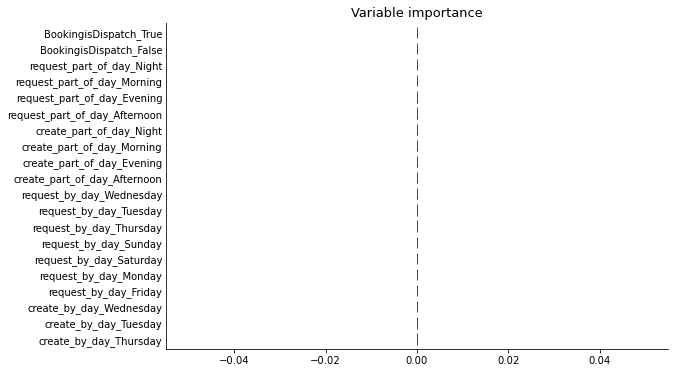

In [11]:
# feature importance
plot_feature_importance(rfcf, X_train.columns)

### 2.3 XGBoost

In [12]:
%%time
xgb = xgboost.XGBClassifier(n_estimators = 500, max_depth = 2, min_samples_weight = 0.05)
xgb.fit(train[mdl_cols],train['target_4cls'])

xbst = xgb.XGBClassifier(objective="multi:softprob", random_state=1)
xbst.fit(X_train,y_train)

NameError: name 'xgboost' is not defined

### 2.4 Support Vector machine

In [ ]:
%%time
clf_SVM = OneVsRestClassifier(LinearSVC())
clf_SVM.fit(X_train,y_train)

In [ ]:
#%%time
#clf_SVM = OneVsRestClassifier(LinearSVC())
#    params = {
#        'estimator__C': [0.5, 1.0, 1.5],
#        'estimator__tol': [1e-3, 1e-4, 1e-5],
#        }
#svm = RandomizedSearchCV(clf_SVM, params, cv=5) #, scoring='roc_auc'

## 3. Training Loss

In [ ]:
# Initialise table
columns=['accuracy', 'f1_score']
rows=['RandomForest','SVM','Logistic']
results =pd.DataFrame(0.0, columns=columns, index=rows)

In [ ]:
%%time
# Computer metrics
results.iloc[0, 0] = 0.942 #accuracy_score(rfcf.predict(X_train), y_train)
results.iloc[0, 1] = 0.9530 #f1_score(rfcf.predict(X_train), y_train, average='weighted')
results.iloc[1, 0] = 0.603 #accuracy_score(clf_SVM.predict(X_train), y_train)
results.iloc[1, 1] = 0.7091 #f1_score(clf_SVM.predict(X_train), y_train, average='weighted')
results.iloc[2, 0] = accuracy_score(lgst.predict(X_train), y_train)
results.iloc[2, 1] = f1_score(lgst.predict(X_train),  y_train, average='weighted')
results.round(4)

## 4. Validation 

In [ ]:
# Initialise table
columns=['accuracy', 'f1_score']
rows=['RandomForest','SVM']
results =pd.DataFrame(0.0, columns=columns, index=rows)

In [ ]:
%%time
# Computer metrics
results.iloc[0, 0] = 0.7518 #accuracy_score(rfcf.predict(X_val), y_val)
results.iloc[0, 1] = 0.7989 #f1_score(rfcf.predict(X_val), y_val, average='weighted')
results.iloc[1, 0] = 0.6035 #accuracy_score(clf_SVM.predict(X_val), y_val)
results.iloc[1, 1] = 0.7096 #f1_score(clf_SVM.predict(X_val), y_val, average='weighted')
results.iloc[2, 0] = accuracy_score(lgst.predict(X_val), y_val)
results.iloc[2, 1] = f1_score(lgst.predict(X_val), y_val, average='weighted')
results.round(4)